# attempt_008
- pake rgb
- cuma prediksi 5 kelas penyakit

# attempt_008
- pake rgb
- cuma prediksi 5 kelas penyakit

# attempt_008
- pake rgb
- cuma prediksi 5 kelas penyakit

In [52]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [53]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

Virtual devices cannot be modified after being initialized


In [54]:
import subprocess

def get_gpu_info():
    try:
        result = subprocess.run(['nvidia-smi'], stdout=subprocess.PIPE, text=True)
        return result.stdout
    except FileNotFoundError:
        return "nvidia-smi not found. Make sure you have NVIDIA GPU and CUDA installed."

gpu_info = get_gpu_info()
print(gpu_info)

Sun Feb 11 14:16:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.99                 Driver Version: 536.99       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   48C    P8               7W /  35W |   2752MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

##### Delete folder before starting

In [55]:
import shutil
import os

def delete_folder(folder_path):
    if os.path.exists(folder_path):
        try:
            shutil.rmtree(folder_path)
            print(f"Folder '{folder_path}' deleted successfully.")
        except OSError as e:
            print(f"Error: {e}")
    else:
        print(f"Folder '{folder_path}' does not exist.")

In [56]:
# train
folder_to_delete = "Apple/train"
delete_folder(folder_to_delete)

# val
folder_to_delete = "Apple/val"
delete_folder(folder_to_delete)

Folder 'Apple/train' deleted successfully.
Folder 'Apple/val' deleted successfully.


# Code

In [57]:
import os 
dir = 'Apple' # this read fodler
print(os.listdir(dir))

['AlternariaBoltch', 'AppleScab', 'BlackRot', 'CedarAppleRust', 'Disease', 'Healthy', 'Rust']


In [58]:
# labels from folder in directory yoooo
labels = os.listdir(dir)
labels.remove("Disease")
labels.remove("Healthy")
labels

['AlternariaBoltch', 'AppleScab', 'BlackRot', 'CedarAppleRust', 'Rust']

In [59]:
# import
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import scipy as sp
import itertools
import zipfile
import cv2

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Conv2D, MaxPooling2D, MaxPool2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import RMSprop

# m8 delete later, should check on it

In [60]:
'''
Abbreviation (so i don't need to write long name)

AlternariaBoltch = boltch
AppleScab = scab
BlackRot = brot
CedarAppleRust = carust
Rust = rust
'''

boltch_dir = os.path.join(dir, 'AlternariaBoltch')
scab_dir = os.path.join(dir, 'AppleScab')
brot_dir = os.path.join(dir, 'BlackRot')
carust_dir = os.path.join(dir, 'CedarAppleRust')
rust_dir = os.path.join(dir, 'Rust')

boltch = os.listdir(boltch_dir)
scab = os.listdir(scab_dir)
brot = os.listdir(brot_dir)
carust = os.listdir(carust_dir)
rust = os.listdir(rust_dir)

In [61]:
import random
import shutil

# Function split
def split_data(src, train_dst, val_dst, split_ratio=0.6):
    files = os.listdir(src)
    random.shuffle(files)

    split_index = int(len(files) * split_ratio)

    train_files = files[:split_index]
    val_files = files[split_index:]

    for file in train_files:
        shutil.copy(os.path.join(src, file), os.path.join(train_dst, file))

    for file in val_files:
        shutil.copy(os.path.join(src, file), os.path.join(val_dst, file))

In [62]:
train_dir = os.path.join(dir, 'train')
val_dir = os.path.join(dir, 'val')

# only use it once
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

os.listdir('Apple/train')
os.listdir('Apple/val')

[]

In [63]:
# only use it once
for i in labels:
    os.makedirs(os.path.join(train_dir, i), exist_ok=True)
    os.makedirs(os.path.join(val_dir, i), exist_ok=True)

In [64]:
# Splitting the data, i hope someone made a better code for this :)
split_data(boltch_dir, os.path.join(train_dir, 'AlternariaBoltch'), os.path.join(val_dir, 'AlternariaBoltch'))
split_data(scab_dir, os.path.join(train_dir, 'AppleScab'), os.path.join(val_dir, 'AppleScab'))
split_data(brot_dir, os.path.join(train_dir, 'BlackRot'), os.path.join(val_dir, 'BlackRot'))
split_data(carust_dir, os.path.join(train_dir, 'CedarAppleRust'), os.path.join(val_dir, 'CedarAppleRust'))
split_data(rust_dir, os.path.join(train_dir, 'Rust'), os.path.join(val_dir, 'Rust'))

In [65]:
# ImageDataGenerator
with tf.device("CPU"):
    
    train_gen = ImageDataGenerator(rescale=1.0/256.0, 
                                zoom_range=0.4, 
                                rotation_range=30,
                                horizontal_flip=True, 
                                vertical_flip=True, 
                                shear_range=0.3, 
                                fill_mode='nearest',
                                width_shift_range=0.2, 
                                height_shift_range=0.2, 
                                validation_split=0.2)
    val_gen = ImageDataGenerator(rescale=1.0/256.0,
                                validation_split=0.2)

In [66]:
with tf.device("CPU"):

    train_dataset = train_gen.flow_from_directory(train_dir, 
                                                target_size=(256, 256), 
                                                color_mode="rgb",
                                                class_mode='categorical', 
                                                batch_size=32)
    val_dataset = val_gen.flow_from_directory(val_dir, 
                                            target_size=(256, 256), 
                                            color_mode="rgb",
                                            class_mode='categorical', 
                                            batch_size=32,
                                            subset='validation')

Found 1250 images belonging to 5 classes.
Found 164 images belonging to 5 classes.


In [67]:
print(train_dataset.class_indices)
print(val_dataset.class_indices)

{'AlternariaBoltch': 0, 'AppleScab': 1, 'BlackRot': 2, 'CedarAppleRust': 3, 'Rust': 4}
{'AlternariaBoltch': 0, 'AppleScab': 1, 'BlackRot': 2, 'CedarAppleRust': 3, 'Rust': 4}


In [68]:
NUM_TRAIN_DATA = train_dataset.n
NUM_VALID_DATA = val_dataset.n

In [69]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3), padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(5, activation='softmax')
])
monitor = EarlyStopping(monitor='val_accuracy',
                        patience=2,
                        verbose=1,
                        mode='max',
                        restore_best_weights=True)

In [70]:
model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 262144)            0         
                                                                 
 dense_8 (Dense)             (None, 128)              

In [71]:
BATCH_SIZE = 2
EPOCHS = 10

In [73]:
# history = model.fit(train_dataset, 
#                     steps_per_epoch=NUM_TRAIN_DATA//BATCH_SIZE,
#                     validation_data=val_dataset,
#                     validation_steps=5,
#                     epochs=EPOCHS,
#                     verbose=2)

history = model.fit(train_dataset,
                    validation_data=val_dataset, 
                    epochs=10, 
                    steps_per_epoch=100, 
                    validation_steps=10, 
                    batch_size=16,
                    verbose=2)


Epoch 1/10


ResourceExhaustedError: Graph execution error:

Detected at node 'sequential_3/conv2d_18/Relu' defined at (most recent call last):
    File "c:\Users\ageng\anaconda3\envs\meong\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\ageng\anaconda3\envs\meong\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\ageng\anaconda3\envs\meong\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\ageng\anaconda3\envs\meong\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "c:\Users\ageng\anaconda3\envs\meong\lib\site-packages\ipykernel\kernelapp.py", line 701, in start
      self.io_loop.start()
    File "c:\Users\ageng\anaconda3\envs\meong\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\ageng\anaconda3\envs\meong\lib\asyncio\windows_events.py", line 321, in run_forever
      super().run_forever()
    File "c:\Users\ageng\anaconda3\envs\meong\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\ageng\anaconda3\envs\meong\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\ageng\anaconda3\envs\meong\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\ageng\anaconda3\envs\meong\lib\site-packages\ipykernel\kernelbase.py", line 534, in dispatch_queue
      await self.process_one()
    File "c:\Users\ageng\anaconda3\envs\meong\lib\site-packages\ipykernel\kernelbase.py", line 523, in process_one
      await dispatch(*args)
    File "c:\Users\ageng\anaconda3\envs\meong\lib\site-packages\ipykernel\kernelbase.py", line 429, in dispatch_shell
      await result
    File "c:\Users\ageng\anaconda3\envs\meong\lib\site-packages\ipykernel\kernelbase.py", line 767, in execute_request
      reply_content = await reply_content
    File "c:\Users\ageng\anaconda3\envs\meong\lib\site-packages\ipykernel\ipkernel.py", line 429, in do_execute
      res = shell.run_cell(
    File "c:\Users\ageng\anaconda3\envs\meong\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\ageng\anaconda3\envs\meong\lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "c:\Users\ageng\anaconda3\envs\meong\lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "c:\Users\ageng\anaconda3\envs\meong\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\ageng\anaconda3\envs\meong\lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\ageng\anaconda3\envs\meong\lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\ageng\anaconda3\envs\meong\lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\ageng\AppData\Local\Temp\ipykernel_2916\2933610120.py", line 8, in <module>
      history = model.fit(train_dataset,
    File "c:\Users\ageng\anaconda3\envs\meong\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\ageng\anaconda3\envs\meong\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\ageng\anaconda3\envs\meong\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\ageng\anaconda3\envs\meong\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\ageng\anaconda3\envs\meong\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\ageng\anaconda3\envs\meong\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\ageng\anaconda3\envs\meong\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\ageng\anaconda3\envs\meong\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\ageng\anaconda3\envs\meong\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\ageng\anaconda3\envs\meong\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\ageng\anaconda3\envs\meong\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\ageng\anaconda3\envs\meong\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Users\ageng\anaconda3\envs\meong\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\ageng\anaconda3\envs\meong\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\ageng\anaconda3\envs\meong\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\ageng\anaconda3\envs\meong\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\ageng\anaconda3\envs\meong\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\ageng\anaconda3\envs\meong\lib\site-packages\keras\layers\convolutional\base_conv.py", line 314, in call
      return self.activation(outputs)
    File "c:\Users\ageng\anaconda3\envs\meong\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "c:\Users\ageng\anaconda3\envs\meong\lib\site-packages\keras\backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'sequential_3/conv2d_18/Relu'
OOM when allocating tensor with shape[32,32,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_3/conv2d_18/Relu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_5933]

6/6 [==============================] - 4s 595ms/step


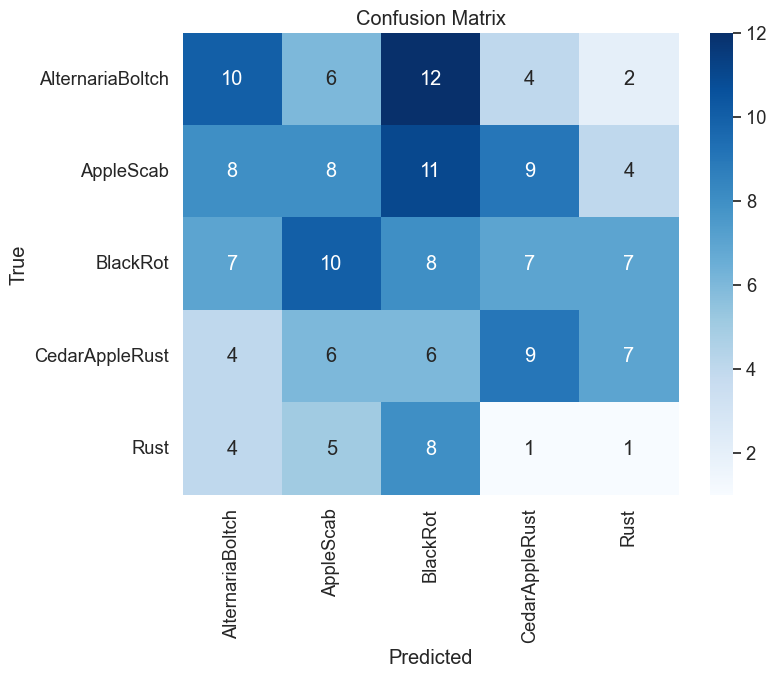

In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

predictions = model.predict(val_dataset, steps=len(val_dataset))
predicted_labels = np.argmax(predictions, axis=1)
true_labels = val_dataset.classes
cm = confusion_matrix(true_labels, predicted_labels)

# Create a seaborn heatmap
sns.set(font_scale=1.2)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
model.save('attempt_008_copy.h5')

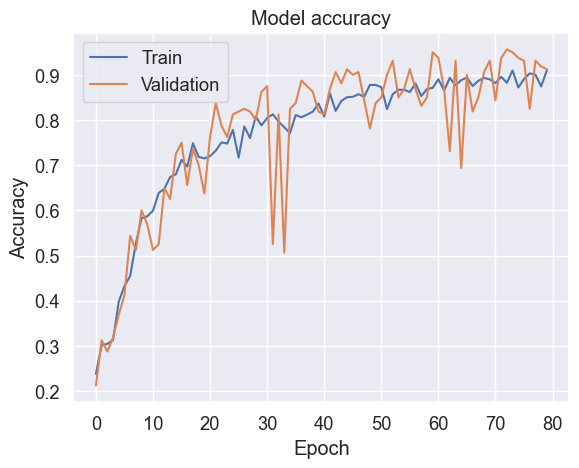

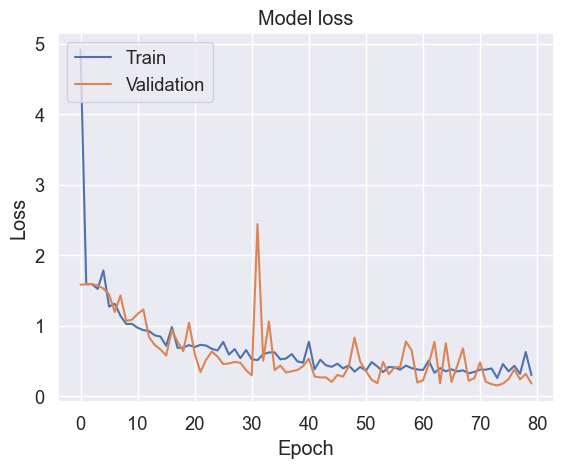

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

6/6 [==============================] - 4s 566ms/step


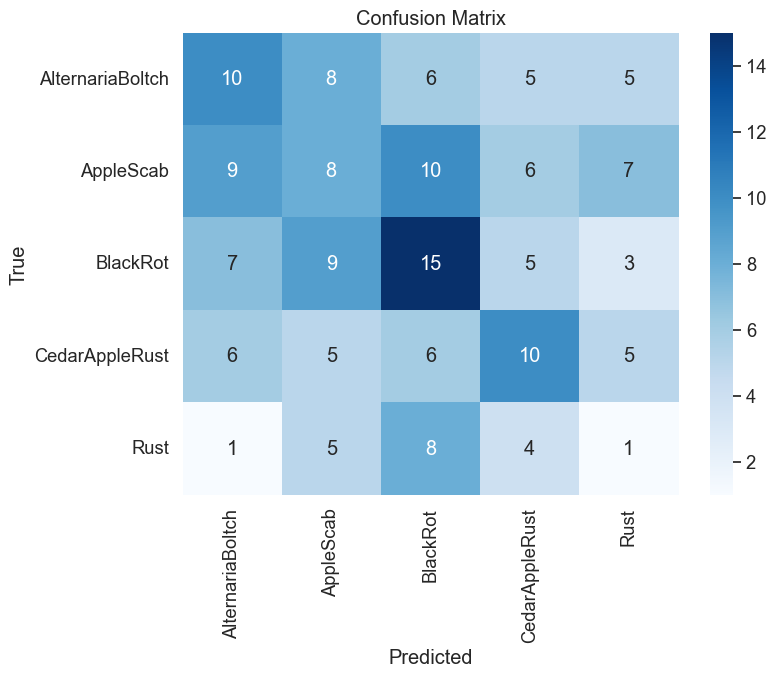

In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

predictions = model.predict(val_dataset, steps=len(val_dataset))
predicted_labels = np.argmax(predictions, axis=1)
true_labels = val_dataset.classes
cm = confusion_matrix(true_labels, predicted_labels)

# Create a seaborn heatmap
sns.set(font_scale=1.2)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

6/6 [==============================] - 4s 550ms/step


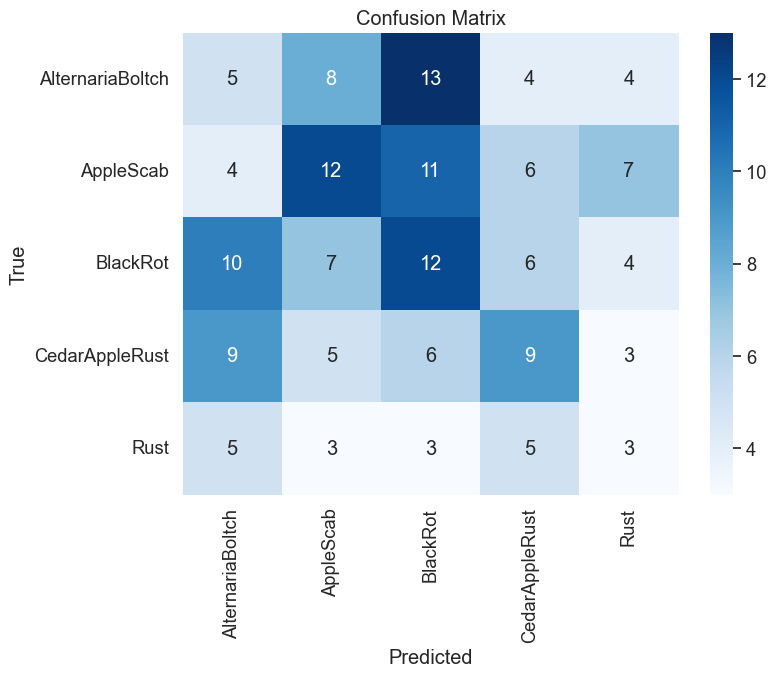

In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

predictions = model.predict(val_dataset, steps=len(val_dataset))
true_labels = val_dataset.classes
cm = confusion_matrix(true_labels, predicted_labels)

# Create a seaborn heatmap
sns.set(font_scale=1.2)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()